In [32]:
from CEG import CEG_analysis
from utility_funcs import get_folds, scale_data, get_train_test, get_RMSE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

## Load me baby

In [3]:
# patient suffixes for file names
mayo_suffs = ['001','002','003','004','005','006','007','008']
sans_suffs = ['01','02','03','04','05','06','07','08','09','10']
data_bypat = {} # holder for data seperated by patient

# loading the data from the pickle files
for s, suff in enumerate(sans_suffs):
    filename = 'feature_data/sansum-%s.p' % suff
    data_bypat['s%s' % (s+1)] = pickle.load(open(filename,'rb'))
    
for m, suff in enumerate(mayo_suffs):
    filename = 'feature_data/mayo-%s.p' % suff
    data_bypat['m%s' % (m+1)] = pickle.load(open(filename,'rb'))

In [4]:
data_bypat['m4'].describe() # ensure data was properly imported

,BG0,BG_PH,BGday_var,dBG30,dBG60,deda30,deda60,dhr30,dhr60,dtemp30,dtemp60,eda0,edaday_var,hr0,hrday_var,step0,t0,temp0,tempday_var
count,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000
mean,168.975459,168.136273,4144.643203,29.359737,29.359737,0.728818,0.728818,18.238566,18.238566,1.428518,1.428518,0.663621,2.302081,95.587401,424.256318,2.181223,12.591979,30.833144,19.535316
std,68.674981,67.501925,1806.688218,41.287753,41.287753,2.718852,2.718852,17.401769,17.401769,2.693323,2.693323,2.284345,11.268824,25.231601,365.901514,2.385042,7.587192,5.499735,16.173875
min,41.000000,41.000000,914.188695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024203,0.000000,49.870867,0.000000,0.005609,0.000000,17.966600,0.000000
25%,115.000000,115.000000,2820.617412,0.000000,0.000000,0.000362,0.000362,5.912075,5.912075,0.102608,0.102608,0.076550,0.145838,79.355900,124.556287,0.346745,5.000000,30.263017,6.358406
50%,159.000000,158.000000,4225.652181,13.000000,13.000000,0.078634,0.078634,13.855767,13.855767,0.615567,0.615567,0.181563,0.352176,86.339667,228.205433,1.426242,14.000000,33.314017,12.829285
75%,216.000000,215.000000,5065.793871,41.000000,41.000000,0.594006,0.594006,24.613050,24.613050,1.452875,1.452875,0.407841,1.019236,104.222633,789.513619,3.131964,19.000000,34.519867,34.795326
max,400.000000,400.000000,10225.061112,346.000000,346.000000,47.825802,47.825802,119.965767,119.965767,16.714900,16.714900,50.569796,104.971496,193.494633,1455.191151,21.416002,23.000000,36.983033,57.202911


## ARMAX CREATION
### I REALLY NEED TO TAKE ONLY CONTINUOUS TIME VALUES FOR BG GIVEN HOW THIS WORKS

In [63]:
# SETUP
folds = get_folds(data_bypat) # get folds
# Number of terms used in each portion of the ARMA model (exog being part of AR)
# in minutes: 0 5 15 30 60 3hrs
AR_degs = np.array([0, 1, 3, 6, 12, 36])
MA_degs = np.array([0, 1, 3, 6, 12, 36])
MSEs = np.zeros([len(AR_degs),len(MA_degs)])

In [86]:
# Get the correct data
test_y, test_x, train_y, train_x, scaler = get_train_test(data_bypat,folds,0)

In [87]:
train_x.loc[:,:] = scaler.inverse_transform(train_x)


In [92]:

for a,ARd in enumerate(AR_degs):
    for m,MAd in enumerate(MA_degs[MA_degs<=ARd]):
        print(a,m, end=': ')
        armax_mod = ARMA(endog=train_x['BG0'], order=[ARd,MAd])# , exog=train_x.drop(columns='BG0'))
        print('built', end=', ')
        try: 
            mod_fit = armax_mod.fit()
            mod_params = mod_fit.params
            print('fit', end=', ')
            # due to a bug with the .predict() function on new data, this workaround must be used to test 
            #armax_mod2 = ARMA(endog=test_x['BG0'], order=[ARd,MAd], exog=test.drop(columns='BG0'))
            test_y_pred = armax_mod.predict(params=mod_params)
            MSEs[a,m] = mean_squared_error(train_x['BG0'], test_y_pred)
        except:
            print('Did not converge')
        print(MSEs[a,m])

0 0: built, fit, 3952.822480091048
1 0: built, fit, 75.90356519442237
1 1: built, fit, 72.40061615539862
2 0: built, fit, 69.46447445290194
2 1: built, fit, 68.50218786703705
2 2: built, fit, 68.49572080501157
3 0: built, fit, 68.52563729132046
3 1: built, fit, 68.49484862653689
3 2: built, fit, 68.48587889278416
3 3: built, Did not converge
0.0
4 0: built, fit, 68.47764050115572
4 1: built, 

C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fit, 68.31391477560223
4 2: built, fit, 68.46978247282462
4 3: built, Did not converge
0.0
4 4: built, Did not converge
0.0
5 0: built, fit, 68.42953167918964
5 1: built, fit, 68.42815211165308
5 2: built, 

C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


fit, 68.26740200349981
5 3: built, 

C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fit, 68.2644530493878
5 4: built, 

C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\coh275\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


fit, 68.27043629577975
5 5: built, Did not converge
0.0


In [85]:
test_y_pred

array([ 9410.80293283, 13125.54555582, 13436.86996165, ...,
       10199.096141  , 10261.36102217, 10385.8907845 ])

In [43]:
armax_mod.endog

array([-0.06773835, -0.14553334, -0.19221033, ..., -1.17242715,
       -1.17242715, -1.17242715])

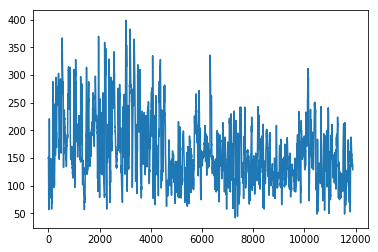

In [68]:
discont = []
for i in range(len(test_y)-1):
    

In [71]:
test_x_og = test_x.copy()
test_x_og.loc[:,:] = scaler.inverse_transform(test_x)

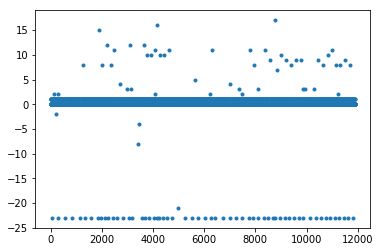

In [81]:
plt.plot(dtime,'.')

In [80]:
dtime=[]
for i in range(len(test_x_og['t0'])-1):
    dtime.append(test_x_og.loc[i+1,'t0']-test_x_og.loc[i,'t0'])

In [90]:
train_x.columns

Index(['BG0', 'BGday_var', 'dBG30', 'dBG60', 'deda30', 'deda60', 'dhr30',
       'dhr60', 'dtemp30', 'dtemp60', 'eda0', 'edaday_var', 'hr0', 'hrday_var',
       'step0', 't0', 'temp0', 'tempday_var'],
      dtype='object')

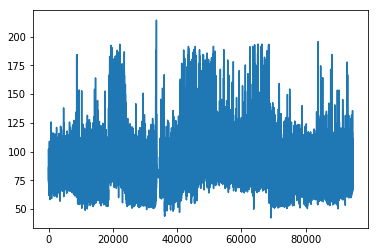

In [91]:
plt.plot(train_x['hr0'])